In [1]:
#imports 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_probability as tfp
tf.compat.v2.enable_v2_behavior()
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

In [2]:
#chirp
def chirp(x, c, f):
    ft = (x*c) + f
    c_sig = np.sin(2*np.pi*ft*x)
    return c_sig

In [3]:
SNR = np.array([0.5,2,5,10])
signal_amp = 1;
Ps = signal_amp**2
Pn = (Ps*10)**(-SNR/10)

chirp_rate = np.array([0, 0.1, 0.2, 0.35, 0.5, 0.7, 0.85, 1])

num_points = 256;
x_vals = np.arange(0,4,4/num_points,).astype(np.float64)
x_vals = x_vals.reshape(num_points,1)

index_points = np.arange(0,4,0.005,).astype(np.float64)
index_points = index_points.reshape(800,1)

In [4]:
num_iters = 200
optimizer = tf.optimizers.Adam(learning_rate=0.01)

(Squared-Exponential x Periodic) + Linear
-----------------------------


In [5]:
mc_norm_error_PeSeL = np.zeros([len(SNR),len(chirp_rate)])

for k in range(len(SNR)):
    for i in range(len(chirp_rate)):


        def build_gp_model(amplitude, length_scale, observation_noise_variance, bias_variance, slope_variance):

            kernel_1 = tfk.ExponentiatedQuadratic(amplitude = amplitude, length_scale = length_scale)
            kernel_2 = tfk.ExpSinSquared(amplitude = amplitude, length_scale = length_scale)
            kernel_3 = tfk.Linear(bias_variance=bias_variance, slope_variance=slope_variance)
            model_kernel = (kernel_1*kernel_2)+kernel_3

            return tfd.GaussianProcess(
              kernel = model_kernel,
              index_points = x_vals,
              observation_noise_variance = observation_noise_variance)

        gp_joint_model = tfd.JointDistributionNamed({
            'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'slope_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'bias_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observations': build_gp_model,
        })

        

        constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

        amplitude_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='amplitude',
            dtype=tf.float64)

        length_scale_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='length_scale',
            dtype=tf.float64)

        observation_noise_variance_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='observation_noise_variance',
            dtype=tf.float64)

        slope_variance_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='slope_variance',
            dtype=tf.float64)

        bias_variance_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='bias_variance',
            dtype=tf.float64)

        trainable_variables = [v.trainable_variables[0] for v in 
                               [amplitude_var,
                               length_scale_var,
                               observation_noise_variance_var,
                               slope_variance_var,
                               bias_variance_var]]


        
        inter_norm_error = np.zeros([10])
        #Monte-Carlo for hyperparameter optimisation 
        for h in range(10):
        
            output = chirp(x_vals, chirp_rate[i], 0.5) + np.random.normal(0, np.sqrt(Pn[k]), 
                                                                          num_points).reshape(num_points,1)
            output = output.reshape(num_points,)
            
            
            @tf.function(autograph=False, experimental_compile=False)
            def target_log_prob(amplitude, length_scale, observation_noise_variance, slope_variance, bias_variance):
                return gp_joint_model.log_prob({
                  'amplitude': amplitude,
                  'length_scale': length_scale,
                  'observation_noise_variance': observation_noise_variance,
                  'slope_variance': slope_variance,
                  'bias_variance': bias_variance,
                  'observations': output
              })


            for j in range(num_iters):
                with tf.GradientTape() as tape:
                    loss = -target_log_prob(amplitude_var, length_scale_var, observation_noise_variance_var,
                                           slope_variance_var, bias_variance_var)
                    grads = tape.gradient(loss, trainable_variables)
                    optimizer.apply_gradients(zip(grads, trainable_variables))


            opt_kernel_1 = tfk.ExponentiatedQuadratic(amplitude = amplitude_var, length_scale = length_scale_var)
            opt_kernel_2 = tfk.ExpSinSquared(amplitude = amplitude_var, length_scale = length_scale_var)
            opt_kernel_3 = tfk.Linear(slope_variance=slope_variance_var, bias_variance = bias_variance_var)
            optimized_kernel = (opt_kernel_1*opt_kernel_2) + opt_kernel_3


            norm_error = np.zeros([5])
            
            #Monte-Carlo for fitting GP
            for n in range(5):

                output = chirp(x_vals, chirp_rate[i], 0.5) + np.random.normal(0, np.sqrt(Pn[k]), 
                                                                              num_points).reshape(num_points,1)
                output = output.reshape(num_points,)


                gprm = tfd.GaussianProcessRegressionModel(
                    kernel = optimized_kernel,
                    index_points = index_points,
                    observation_index_points = x_vals,
                    observations = output,
                    observation_noise_variance = observation_noise_variance_var,
                    predictive_noise_variance=0.)

                mean_func = gprm.mean_fn
                mean_line = mean_func(index_points)

                norm_error[n] = np.sqrt(np.sum((mean_line - chirp(index_points, chirp_rate[i], 0.5).reshape(800))**2))

            inter_norm_error[h] = np.mean(norm_error)
        
        mc_norm_error_PeSeL[k,i] = np.mean(inter_norm_error)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


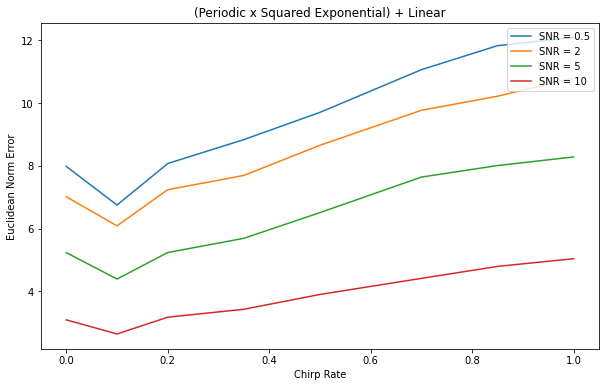

In [6]:
fig1 = plt.figure(figsize = (10,6))
plt.plot(chirp_rate, mc_norm_error_PeSeL[0,], label = 'SNR = 0.5')
plt.plot(chirp_rate, mc_norm_error_PeSeL[1,], label = 'SNR = 2')
plt.plot(chirp_rate, mc_norm_error_PeSeL[2,], label = 'SNR = 5')
plt.plot(chirp_rate, mc_norm_error_PeSeL[3,], label = 'SNR = 10')

leg = plt.legend(loc='upper right')
plt.xlabel('Chirp Rate')
plt.ylabel('Euclidean Norm Error')
plt.title('(Periodic x Squared Exponential) + Linear')

fig1.savefig('SExPe+Lin_vary_chirp.png')

In [9]:
mc_norm_error_PeSeL

array([[ 8.07635081,  6.81975776,  8.00965839,  9.09423258, 10.10571112,
        10.94162423, 11.63870238, 12.19025175],
       [ 6.79223196,  5.81370593,  7.06702125,  7.7957342 ,  8.44505507,
         9.68116659, 10.11233316, 10.78075977],
       [ 4.98478621,  4.5385971 ,  5.20863353,  5.71694687,  6.40178183,
         7.23251921,  7.67357482,  8.35372918],
       [ 3.06383181,  2.62203857,  3.11557683,  3.45973822,  3.89159661,
         4.34536054,  4.73003326,  5.09109426]])

---------------------------



Squared Exponential Kernel
-----------------------------

----------------------------

In [10]:
mc_norm_error_Se = np.zeros([len(SNR),len(chirp_rate)])

for k in range(len(SNR)):
    for i in range(len(chirp_rate)):


        def build_gp_model(amplitude, length_scale, observation_noise_variance):

            model_kernel = tfk.ExponentiatedQuadratic(amplitude = amplitude, length_scale = length_scale)

            return tfd.GaussianProcess(
              kernel = model_kernel,
              index_points = x_vals,
              observation_noise_variance = observation_noise_variance)

        gp_joint_model = tfd.JointDistributionNamed({
            'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observations': build_gp_model,
        })
        

        constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

        amplitude_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='amplitude',
            dtype=tf.float64)

        length_scale_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='length_scale',
            dtype=tf.float64)

        observation_noise_variance_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='observation_noise_variance_var',
            dtype=tf.float64)

        trainable_variables = [v.trainable_variables[0] for v in 
                               [amplitude_var,
                               length_scale_var,
                               observation_noise_variance_var]]

        inter_norm_error = np.zeros([10])
        for h in range(10):
            
            output = chirp(x_vals, chirp_rate[i], 0.5) + np.random.normal(0, np.sqrt(Pn[k]), 
                                                                          num_points).reshape(num_points,1)
            output = output.reshape(num_points,)

            @tf.function(autograph=False, experimental_compile=False)
            def target_log_prob(amplitude, length_scale, observation_noise_variance):
                return gp_joint_model.log_prob({
                  'amplitude': amplitude,
                  'length_scale': length_scale,
                  'observation_noise_variance': observation_noise_variance,
                  'observations': output
                })


            for j in range(num_iters):
                with tf.GradientTape() as tape:
                    loss = -target_log_prob(amplitude_var, length_scale_var, observation_noise_variance_var)
                    grads = tape.gradient(loss, trainable_variables)
                    optimizer.apply_gradients(zip(grads, trainable_variables))


            optimized_kernel = tfk.ExponentiatedQuadratic(amplitude = amplitude_var, length_scale = length_scale_var)      

            norm_error = np.zeros([5])
            #start loopin
            for n in range(5):

                output = chirp(x_vals, chirp_rate[i], 0.5) + np.random.normal(0, np.sqrt(Pn[k]), 
                                                                              num_points).reshape(num_points,1)
                output = output.reshape(num_points,)


                gprm = tfd.GaussianProcessRegressionModel(
                    kernel = optimized_kernel,
                    index_points = index_points,
                    observation_index_points = x_vals,
                    observations = output,
                    observation_noise_variance = observation_noise_variance_var,
                    predictive_noise_variance=0.)

                mean_func = gprm.mean_fn
                mean_line = mean_func(index_points)

                norm_error[n] = np.sqrt(np.sum((mean_line - chirp(index_points, chirp_rate[i], 0.5).reshape(800))**2))

            inter_norm_error[h] = np.mean(norm_error)

        mc_norm_error_Se[k,i] = np.mean(inter_norm_error)

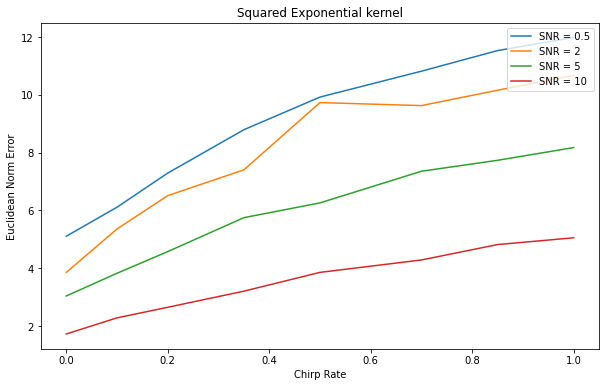

In [11]:
fig2 = plt.figure(figsize = (10,6))
plt.plot(chirp_rate, mc_norm_error_Se[0,], label = 'SNR = 0.5')
plt.plot(chirp_rate, mc_norm_error_Se[1,], label = 'SNR = 2')
plt.plot(chirp_rate, mc_norm_error_Se[2,], label = 'SNR = 5')
plt.plot(chirp_rate, mc_norm_error_Se[3,], label = 'SNR = 10')

leg = plt.legend(loc='upper right')
plt.xlabel('Chirp Rate')
plt.ylabel('Euclidean Norm Error')
plt.title('Squared Exponential kernel')

fig2.savefig('SE_vary_chirp.png')

In [12]:
mc_norm_error_Se

array([[ 5.11138581,  6.11437835,  7.29414904,  8.79249249,  9.92116806,
        10.81630427, 11.52802921, 11.98271432],
       [ 3.85986776,  5.36173524,  6.51425685,  7.40550384,  9.73097352,
         9.62659929, 10.15788456, 10.67088081],
       [ 3.04509561,  3.83034398,  4.5794083 ,  5.75155086,  6.26284629,
         7.356862  ,  7.73526086,  8.17471776],
       [ 1.73070977,  2.2883416 ,  2.65367181,  3.21047802,  3.86031477,
         4.2890753 ,  4.82158031,  5.05611596]])

----------------------------
Periodic x Squared Exponential
------------------------

In [13]:
mc_norm_error_PeSe = np.zeros([len(SNR),len(chirp_rate)])

for k in range(len(SNR)):
    for i in range(len(chirp_rate)):


        def build_gp_model(amplitude, length_scale, observation_noise_variance):

            kernel1 = tfk.ExpSinSquared(amplitude = amplitude, length_scale = length_scale)
            kernel2 = tfk.ExponentiatedQuadratic(amplitude = amplitude, length_scale = length_scale)
            model_kernel = kernel1*kernel2

            return tfd.GaussianProcess(
              kernel = model_kernel,
              index_points = x_vals,
              observation_noise_variance = observation_noise_variance)

        gp_joint_model = tfd.JointDistributionNamed({
            'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observations': build_gp_model,
        })
        

        constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

        amplitude_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='amplitude',
            dtype=tf.float64)

        length_scale_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='length_scale',
            dtype=tf.float64)

        observation_noise_variance_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='observation_noise_variance_var',
            dtype=tf.float64)

        trainable_variables = [v.trainable_variables[0] for v in 
                               [amplitude_var,
                               length_scale_var,
                               observation_noise_variance_var]]
        
        
        inter_norm_error = np.zeros([10])
        for h in range(10):

            output = chirp(x_vals, chirp_rate[i], 0.5) + np.random.normal(0, np.sqrt(Pn[k]), num_points).reshape(num_points,1)
            output = output.reshape(num_points,)

            @tf.function(autograph=False, experimental_compile=False)
            def target_log_prob(amplitude, length_scale, observation_noise_variance):
                return gp_joint_model.log_prob({
                  'amplitude': amplitude,
                  'length_scale': length_scale,
                  'observation_noise_variance': observation_noise_variance,
                  'observations': output
                })


            for j in range(num_iters):
                with tf.GradientTape() as tape:
                    loss = -target_log_prob(amplitude_var, length_scale_var, observation_noise_variance_var)
                    grads = tape.gradient(loss, trainable_variables)
                    optimizer.apply_gradients(zip(grads, trainable_variables))



            opt_kernel1 = tfk.ExpSinSquared(amplitude = amplitude_var, length_scale = length_scale_var)
            opt_kernel2 = tfk.ExponentiatedQuadratic(amplitude = amplitude_var, length_scale = length_scale_var)
            optimized_kernel = opt_kernel1*opt_kernel2      

            norm_error = np.zeros([5])
            #start loopin
            for n in range(5):

                output = chirp(x_vals, chirp_rate[i], 0.5) + np.random.normal(0, np.sqrt(Pn[k]), 
                                                                              num_points).reshape(num_points,1)
                output = output.reshape(num_points,)


                gprm = tfd.GaussianProcessRegressionModel(
                    kernel = optimized_kernel,
                    index_points = index_points,
                    observation_index_points = x_vals,
                    observations = output,
                    observation_noise_variance = observation_noise_variance_var,
                    predictive_noise_variance=0.)

                mean_func = gprm.mean_fn
                mean_line = mean_func(index_points)

                norm_error[n] = np.sqrt(np.sum((mean_line - chirp(index_points, chirp_rate[i], 0.5).reshape(800))**2))

            inter_norm_error[h] = np.mean(norm_error)

        mc_norm_error_PeSe[k,i] = np.mean(inter_norm_error)

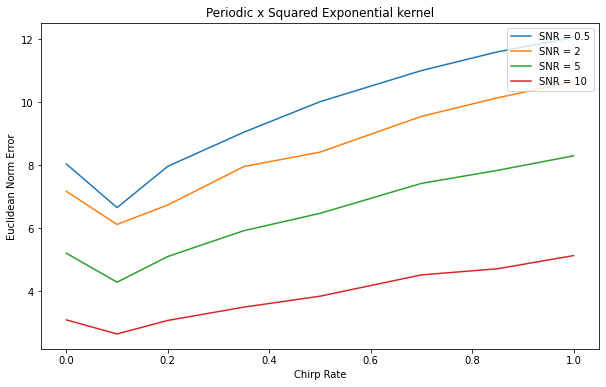

In [14]:
fig3 = plt.figure(figsize = (10,6))
plt.plot(chirp_rate, mc_norm_error_PeSe[0,], label = 'SNR = 0.5')
plt.plot(chirp_rate, mc_norm_error_PeSe[1,], label = 'SNR = 2')
plt.plot(chirp_rate, mc_norm_error_PeSe[2,], label = 'SNR = 5')
plt.plot(chirp_rate, mc_norm_error_PeSe[3,], label = 'SNR = 10')

leg = plt.legend(loc='upper right')
plt.xlabel('Chirp Rate')
plt.ylabel('Euclidean Norm Error')
plt.title('Periodic x Squared Exponential kernel')

fig3.savefig('PExSE_vary_chirp.png')

In [16]:
mc_norm_error_PeSe

array([[ 8.04423427,  6.65974951,  7.96863223,  9.05190286, 10.01690649,
        11.00528533, 11.59897487, 12.0554835 ],
       [ 7.17627359,  6.12551135,  6.74276399,  7.9618058 ,  8.41769058,
         9.5518888 , 10.14111082, 10.65459355],
       [ 5.21269137,  4.29404558,  5.10888436,  5.92793981,  6.47682472,
         7.42751594,  7.84071488,  8.30240356],
       [ 3.09888161,  2.6517933 ,  3.08125188,  3.50298067,  3.84960245,
         4.52536711,  4.71936238,  5.13828759]])

--------------------------
Periodic Kernel
---------------------------


In [17]:
mc_norm_error_Pe = np.zeros([len(SNR),len(chirp_rate)])

for k in range(len(SNR)):
    for i in range(len(chirp_rate)):

        def build_gp_model(amplitude, length_scale, observation_noise_variance):

            model_kernel = tfk.ExpSinSquared(amplitude = amplitude, length_scale = length_scale)

            return tfd.GaussianProcess(
              kernel = model_kernel,
              index_points = x_vals,
              observation_noise_variance = observation_noise_variance)

        gp_joint_model = tfd.JointDistributionNamed({
            'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observations': build_gp_model,
        })
        

        constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

        amplitude_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='amplitude',
            dtype=tf.float64)

        length_scale_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='length_scale',
            dtype=tf.float64)

        observation_noise_variance_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='observation_noise_variance_var',
            dtype=tf.float64)

        trainable_variables = [v.trainable_variables[0] for v in 
                               [amplitude_var,
                               length_scale_var,
                               observation_noise_variance_var]]
        

        inter_norm_error = np.zeros([10])
        for h in range(10):

            output = chirp(x_vals, chirp_rate[i], 0.5) + np.random.normal(0, np.sqrt(Pn[k]), 
                                                                          num_points).reshape(num_points,1)
            output = output.reshape(num_points,)


            @tf.function(autograph=False, experimental_compile=False)
            def target_log_prob(amplitude, length_scale, observation_noise_variance):
                return gp_joint_model.log_prob({
                  'amplitude': amplitude,
                  'length_scale': length_scale,
                  'observation_noise_variance': observation_noise_variance,
                  'observations': output
                })

            
            for j in range(num_iters):
                with tf.GradientTape() as tape:
                    loss = -target_log_prob(amplitude_var, length_scale_var, observation_noise_variance_var)
                    grads = tape.gradient(loss, trainable_variables)
                    optimizer.apply_gradients(zip(grads, trainable_variables))


            optimized_kernel = tfk.ExpSinSquared(amplitude = amplitude_var, length_scale = length_scale_var)      

            norm_error = np.zeros([5])
            #start loopin
            for n in range(5):

                output = chirp(x_vals, chirp_rate[i], 0.5) + np.random.normal(0, np.sqrt(Pn[k]), 
                                                                              num_points).reshape(num_points,1)
                output = output.reshape(num_points,)


                gprm = tfd.GaussianProcessRegressionModel(
                    kernel = optimized_kernel,
                    index_points = index_points,
                    observation_index_points = x_vals,
                    observations = output,
                    observation_noise_variance = observation_noise_variance_var,
                    predictive_noise_variance=0.)

                mean_func = gprm.mean_fn
                mean_line = mean_func(index_points)

                norm_error[n] = np.sqrt(np.sum((mean_line - chirp(index_points, chirp_rate[i], 0.5).reshape(800))**2))

            inter_norm_error[h] = np.mean(norm_error)

        mc_norm_error_Pe[k,i] = np.mean(inter_norm_error)

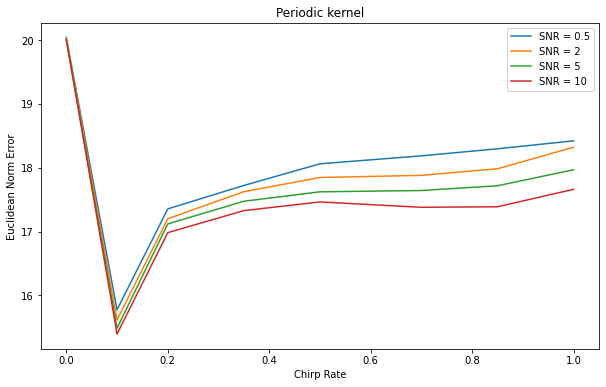

In [18]:
fig4 = plt.figure(figsize = (10,6))
plt.plot(chirp_rate, mc_norm_error_Pe[0,], label = 'SNR = 0.5')
plt.plot(chirp_rate, mc_norm_error_Pe[1,], label = 'SNR = 2')
plt.plot(chirp_rate, mc_norm_error_Pe[2,], label = 'SNR = 5')
plt.plot(chirp_rate, mc_norm_error_Pe[3,], label = 'SNR = 10')

leg = plt.legend(loc='upper right')
plt.xlabel('Chirp Rate')
plt.ylabel('Euclidean Norm Error')
plt.title('Periodic kernel')

fig4.savefig('PE_vary_chirp.png')

In [20]:
mc_norm_error_Pe

array([[20.03988401, 15.77427059, 17.35426894, 17.7217458 , 18.06034976,
        18.18521125, 18.29554597, 18.42028094],
       [20.02619625, 15.61483914, 17.19950483, 17.62363651, 17.84618114,
        17.87980578, 17.98323637, 18.32095275],
       [20.01023343, 15.48436608, 17.11911415, 17.47393674, 17.62171448,
        17.64233886, 17.71663972, 17.96741106],
       [20.00324793, 15.3946945 , 16.98217597, 17.32722757, 17.46313875,
        17.37930961, 17.38747723, 17.66087424]])

Rational Quadratic
----------------------

In [6]:
mc_norm_error_Rq = np.zeros([len(SNR),len(chirp_rate)])

for k in range(len(SNR)):
    for i in range(len(chirp_rate)):

        def build_gp_model(amplitude, length_scale, scale_mixture_rate, observation_noise_variance):

            model_kernel = tfk.RationalQuadratic(amplitude = amplitude, 
                                         length_scale = length_scale, scale_mixture_rate= scale_mixture_rate)

            return tfd.GaussianProcess(
              kernel = model_kernel,
              index_points = x_vals,
              observation_noise_variance = observation_noise_variance)

        gp_joint_model = tfd.JointDistributionNamed({
            'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'scale_mixture_rate': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observations': build_gp_model,
        })
        

        constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

        amplitude_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='amplitude',
            dtype=tf.float64)

        length_scale_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='length_scale',
            dtype=tf.float64)

        scale_mixture_rate_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='scale_mixture_rate',
            dtype=tf.float64)
        
        observation_noise_variance_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='observation_noise_variance_var',
            dtype=tf.float64)

        trainable_variables = [v.trainable_variables[0] for v in 
                               [amplitude_var,
                               length_scale_var,
                               scale_mixture_rate_var,
                               observation_noise_variance_var]]
        

        inter_norm_error = np.zeros([10])
        for h in range(10):

            output = chirp(x_vals, chirp_rate[i], 0.5) + np.random.normal(0, np.sqrt(Pn[k]), 
                                                                          num_points).reshape(num_points,1)
            output = output.reshape(num_points,)


            @tf.function(autograph=False, experimental_compile=False)
            def target_log_prob(amplitude, length_scale, scale_mixture_rate, observation_noise_variance):
                return gp_joint_model.log_prob({
                  'amplitude': amplitude,
                  'length_scale': length_scale,
                  'scale_mixture_rate':scale_mixture_rate,
                  'observation_noise_variance': observation_noise_variance,
                  'observations': output
                })

            
            for j in range(num_iters):
                with tf.GradientTape() as tape:
                    loss = -target_log_prob(amplitude_var, length_scale_var, 
                                            scale_mixture_rate_var, observation_noise_variance_var)
                    grads = tape.gradient(loss, trainable_variables)
                    optimizer.apply_gradients(zip(grads, trainable_variables))


            optimized_kernel = tfk.RationalQuadratic(amplitude = amplitude_var, 
                                         length_scale = length_scale_var, scale_mixture_rate = scale_mixture_rate_var)      

            norm_error = np.zeros([5])
            #start loopin
            for n in range(5):

                output = chirp(x_vals, chirp_rate[i], 0.5) + np.random.normal(0, np.sqrt(Pn[k]), 
                                                                              num_points).reshape(num_points,1)
                output = output.reshape(num_points,)


                gprm = tfd.GaussianProcessRegressionModel(
                    kernel = optimized_kernel,
                    index_points = index_points,
                    observation_index_points = x_vals,
                    observations = output,
                    observation_noise_variance = observation_noise_variance_var,
                    predictive_noise_variance=0.)

                mean_func = gprm.mean_fn
                mean_line = mean_func(index_points)

                norm_error[n] = np.sqrt(np.sum((mean_line - chirp(index_points, chirp_rate[i], 0.5).reshape(800))**2))

            inter_norm_error[h] = np.mean(norm_error)

        mc_norm_error_Rq[k,i] = np.mean(inter_norm_error)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


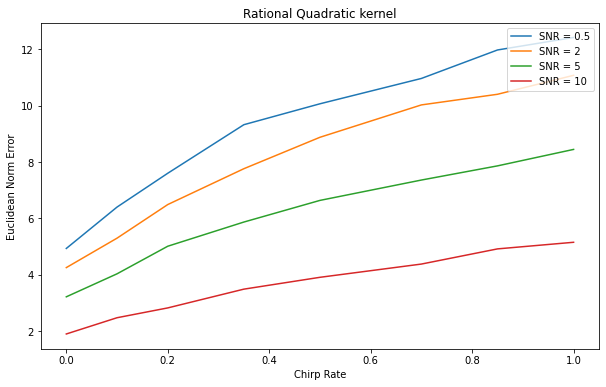

In [7]:
fig5 = plt.figure(figsize = (10,6))
plt.plot(chirp_rate, mc_norm_error_Rq[0,], label = 'SNR = 0.5')
plt.plot(chirp_rate, mc_norm_error_Rq[1,], label = 'SNR = 2')
plt.plot(chirp_rate, mc_norm_error_Rq[2,], label = 'SNR = 5')
plt.plot(chirp_rate, mc_norm_error_Rq[3,], label = 'SNR = 10')

leg = plt.legend(loc='upper right')
plt.xlabel('Chirp Rate')
plt.ylabel('Euclidean Norm Error')
plt.title('Rational Quadratic kernel')

fig5.savefig('RQ_vary_chirp.png')

In [8]:
mc_norm_error_Rq

array([[ 4.93103848,  6.39995241,  7.60052946,  9.3239565 , 10.06609456,
        10.96579766, 11.97637005, 12.42046598],
       [ 4.25102242,  5.29637869,  6.48951568,  7.76154709,  8.87694764,
        10.02638757, 10.40368067, 11.07704534],
       [ 3.2142485 ,  4.03062416,  5.00993363,  5.86829001,  6.63659265,
         7.35927626,  7.86214851,  8.44643836],
       [ 1.89500618,  2.47165907,  2.82033344,  3.48626657,  3.90653828,
         4.37677415,  4.91524182,  5.15009242]])

-----------
Matern 3/2
----------

In [5]:
mc_norm_error_Ma_3h = np.zeros([len(SNR),len(chirp_rate)])

for k in range(len(SNR)):
    for i in range(len(chirp_rate)):


        def build_gp_model(amplitude, length_scale, observation_noise_variance):

            model_kernel = tfk.MaternThreeHalves(amplitude = amplitude, length_scale = length_scale)

            return tfd.GaussianProcess(
              kernel = model_kernel,
              index_points = x_vals,
              observation_noise_variance = observation_noise_variance)

        gp_joint_model = tfd.JointDistributionNamed({
            'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observations': build_gp_model,
        })
        

        constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

        amplitude_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='amplitude',
            dtype=tf.float64)

        length_scale_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='length_scale',
            dtype=tf.float64)

        observation_noise_variance_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='observation_noise_variance_var',
            dtype=tf.float64)

        trainable_variables = [v.trainable_variables[0] for v in 
                               [amplitude_var,
                               length_scale_var,
                               observation_noise_variance_var]]

        inter_norm_error = np.zeros([10])
        for h in range(10):
            
            output = chirp(x_vals, chirp_rate[i], 0.5) + np.random.normal(0, np.sqrt(Pn[k]), 
                                                                          num_points).reshape(num_points,1)
            output = output.reshape(num_points,)

            @tf.function(autograph=False, experimental_compile=False)
            def target_log_prob(amplitude, length_scale, observation_noise_variance):
                return gp_joint_model.log_prob({
                  'amplitude': amplitude,
                  'length_scale': length_scale,
                  'observation_noise_variance': observation_noise_variance,
                  'observations': output
                })


            for j in range(num_iters):
                with tf.GradientTape() as tape:
                    loss = -target_log_prob(amplitude_var, length_scale_var, observation_noise_variance_var)
                    grads = tape.gradient(loss, trainable_variables)
                    optimizer.apply_gradients(zip(grads, trainable_variables))


            optimized_kernel = tfk.MaternThreeHalves(amplitude = amplitude_var, length_scale = length_scale_var)      

            norm_error = np.zeros([5])
            #start loopin
            for n in range(5):

                output = chirp(x_vals, chirp_rate[i], 0.5) + np.random.normal(0, np.sqrt(Pn[k]), 
                                                                              num_points).reshape(num_points,1)
                output = output.reshape(num_points,)


                gprm = tfd.GaussianProcessRegressionModel(
                    kernel = optimized_kernel,
                    index_points = index_points,
                    observation_index_points = x_vals,
                    observations = output,
                    observation_noise_variance = observation_noise_variance_var,
                    predictive_noise_variance=0.)

                mean_func = gprm.mean_fn
                mean_line = mean_func(index_points)

                norm_error[n] = np.sqrt(np.sum((mean_line - chirp(index_points, chirp_rate[i], 0.5).reshape(800))**2))

            inter_norm_error[h] = np.mean(norm_error)

        mc_norm_error_Ma_3h[k,i] = np.mean(inter_norm_error)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


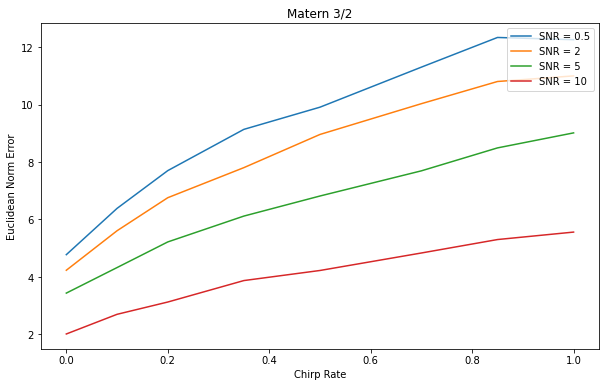

In [10]:
fig6 = plt.figure(figsize = (10,6))
plt.plot(chirp_rate, mc_norm_error_Ma_3h[0,], label = 'SNR = 0.5')
plt.plot(chirp_rate, mc_norm_error_Ma_3h[1,], label = 'SNR = 2')
plt.plot(chirp_rate, mc_norm_error_Ma_3h[2,], label = 'SNR = 5')
plt.plot(chirp_rate, mc_norm_error_Ma_3h[3,], label = 'SNR = 10')

leg = plt.legend(loc='upper right')
plt.xlabel('Chirp Rate')
plt.ylabel('Euclidean Norm Error')
plt.title('Matern 3/2')

fig6.savefig('Ma3h_vary_chirp.png')

------------
Matern 5/2
------------

In [8]:
mc_norm_error_Ma_5h = np.zeros([len(SNR),len(chirp_rate)])

for k in range(len(SNR)):
    for i in range(len(chirp_rate)):


        def build_gp_model(amplitude, length_scale, observation_noise_variance):

            model_kernel = tfk.MaternFiveHalves(amplitude = amplitude, length_scale = length_scale)

            return tfd.GaussianProcess(
              kernel = model_kernel,
              index_points = x_vals,
              observation_noise_variance = observation_noise_variance)

        gp_joint_model = tfd.JointDistributionNamed({
            'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observations': build_gp_model,
        })
        

        constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

        amplitude_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='amplitude',
            dtype=tf.float64)

        length_scale_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='length_scale',
            dtype=tf.float64)

        observation_noise_variance_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='observation_noise_variance_var',
            dtype=tf.float64)

        trainable_variables = [v.trainable_variables[0] for v in 
                               [amplitude_var,
                               length_scale_var,
                               observation_noise_variance_var]]

        inter_norm_error = np.zeros([10])
        for h in range(10):
            
            output = chirp(x_vals, chirp_rate[i], 0.5) + np.random.normal(0, np.sqrt(Pn[k]), 
                                                                          num_points).reshape(num_points,1)
            output = output.reshape(num_points,)

            @tf.function(autograph=False, experimental_compile=False)
            def target_log_prob(amplitude, length_scale, observation_noise_variance):
                return gp_joint_model.log_prob({
                  'amplitude': amplitude,
                  'length_scale': length_scale,
                  'observation_noise_variance': observation_noise_variance,
                  'observations': output
                })


            for j in range(num_iters):
                with tf.GradientTape() as tape:
                    loss = -target_log_prob(amplitude_var, length_scale_var, observation_noise_variance_var)
                    grads = tape.gradient(loss, trainable_variables)
                    optimizer.apply_gradients(zip(grads, trainable_variables))


            optimized_kernel = tfk.MaternFiveHalves(amplitude = amplitude_var, length_scale = length_scale_var)      

            norm_error = np.zeros([5])
            #start loopin
            for n in range(5):

                output = chirp(x_vals, chirp_rate[i], 0.5) + np.random.normal(0, np.sqrt(Pn[k]), 
                                                                              num_points).reshape(num_points,1)
                output = output.reshape(num_points,)


                gprm = tfd.GaussianProcessRegressionModel(
                    kernel = optimized_kernel,
                    index_points = index_points,
                    observation_index_points = x_vals,
                    observations = output,
                    observation_noise_variance = observation_noise_variance_var,
                    predictive_noise_variance=0.)

                mean_func = gprm.mean_fn
                mean_line = mean_func(index_points)

                norm_error[n] = np.sqrt(np.sum((mean_line - chirp(index_points, chirp_rate[i], 0.5).reshape(800))**2))

            inter_norm_error[h] = np.mean(norm_error)

        mc_norm_error_Ma_5h[k,i] = np.mean(inter_norm_error)

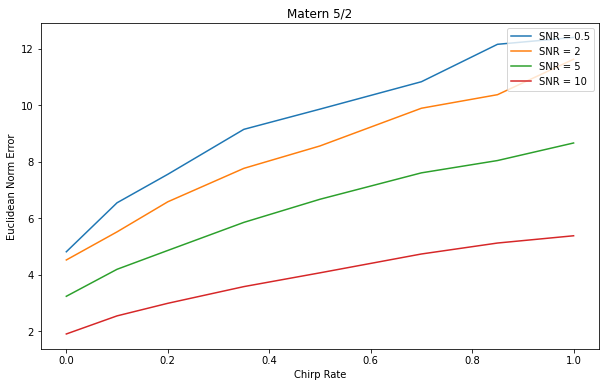

In [11]:
fig7 = plt.figure(figsize = (10,6))
plt.plot(chirp_rate, mc_norm_error_Ma_5h[0,], label = 'SNR = 0.5')
plt.plot(chirp_rate, mc_norm_error_Ma_5h[1,], label = 'SNR = 2')
plt.plot(chirp_rate, mc_norm_error_Ma_5h[2,], label = 'SNR = 5')
plt.plot(chirp_rate, mc_norm_error_Ma_5h[3,], label = 'SNR = 10')

leg = plt.legend(loc='upper right')
plt.xlabel('Chirp Rate')
plt.ylabel('Euclidean Norm Error')
plt.title('Matern 5/2')

fig7.savefig('Ma5h_vary_chirp.png')